In [1]:
import pandas as pd
import numpy as np
from prettytable import PrettyTable
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings

from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import  DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [ ]:
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('diabetic_data.csv')
data

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [3]:
print(np.unique(data['age']))

replaceDict = {'[0-10)' : 5,
'[10-20)' : 15,
'[20-30)' : 25,
'[30-40)' : 35,
'[40-50)' : 45,
'[50-60)' : 55,
'[60-70)' : 65,
'[70-80)' : 75,
'[80-90)' : 85,
'[90-100)' : 95}

data['age'] = data['age'].apply(lambda x : replaceDict[x])
print(data['age'].head())

['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
0     5
1    15
2    25
3    35
4    45
Name: age, dtype: int64


In [4]:
# data.dropna(inplace = True)
print('Total data = ', len(data))
print('Unique entries = ', len(np.unique(data['patient_nbr'])))
data.drop_duplicates(['patient_nbr'], keep = 'first', inplace = True)
print('Length after removing Duplicates:', len(data))

Total data =  101766
Unique entries =  71518
Length after removing Duplicates: 71518


In [5]:
t = PrettyTable(['Column Name', 'Missing Values', 'Missing Percentage'])
for col in data.columns :
    lenn = len(data[data[col] == '?'])
    t.add_row([col,lenn,lenn / len(data)])
print(t)

+--------------------------+----------------+-----------------------+
|       Column Name        | Missing Values |   Missing Percentage  |
+--------------------------+----------------+-----------------------+
|       encounter_id       |       0        |          0.0          |
|       patient_nbr        |       0        |          0.0          |
|           race           |      1948      |  0.027237898151514305 |
|          gender          |       0        |          0.0          |
|           age            |       0        |          0.0          |
|          weight          |     68665      |   0.960107944853044   |
|    admission_type_id     |       0        |          0.0          |
| discharge_disposition_id |       0        |          0.0          |
|   admission_source_id    |       0        |          0.0          |
|     time_in_hospital     |       0        |          0.0          |
|        payer_code        |     31043      |   0.434058558684527   |
|    medical_special

In [6]:
high_frequency = ['InternalMedicine', 'Family/GeneralPractice', 'Cardiology', 'Surgery-General', 'Orthopedics', 'Orthopedics-Reconstructive',
                 'Emergency/Trauma', 'Urology','ObstetricsandGynecology','Psychiatry','Pulmonology ','Nephrology','Radiologist']

low_frequency = ['Surgery-PlasticwithinHeadandNeck','Psychiatry-Addictive','Proctology','Dermatology','SportsMedicine','Speech','Perinatology',\
                'Neurophysiology','Resident','Pediatrics-Hematology-Oncology','Pediatrics-EmergencyMedicine','Dentistry','DCPTEAM','Psychiatry-Child/Adolescent',\
                'Pediatrics-Pulmonology','Surgery-Pediatric','AllergyandImmunology','Pediatrics-Neurology','Anesthesiology','Pathology','Cardiology-Pediatric',\
                'Endocrinology-Metabolism','PhysicianNotFound','Surgery-Colon&Rectal','OutreachServices',\
                'Surgery-Maxillofacial','Rheumatology','Anesthesiology-Pediatric','Obstetrics','Obsterics&Gynecology-GynecologicOnco']

pediatrics = ['Pediatrics','Pediatrics-CriticalCare','Pediatrics-EmergencyMedicine','Pediatrics-Endocrinology','Pediatrics-Hematology-Oncology',\
               'Pediatrics-Neurology','Pediatrics-Pulmonology', 'Anesthesiology-Pediatric', 'Cardiology-Pediatric', 'Surgery-Pediatric']

psychic = ['Psychiatry-Addictive', 'Psychology', 'Psychiatry',  'Psychiatry-Child/Adolescent', 'PhysicalMedicineandRehabilitation', 'Osteopath']


neurology = ['Neurology', 'Surgery-Neuro',  'Pediatrics-Neurology', 'Neurophysiology']


surgery = ['Surgeon', 'Surgery-Cardiovascular', \
          'Surgery-Cardiovascular/Thoracic', 'Surgery-Colon&Rectal', 'Surgery-General', 'Surgery-Maxillofacial', \
             'Surgery-Plastic', 'Surgery-PlasticwithinHeadandNeck',  'Surgery-Thoracic',\
             'Surgery-Vascular', 'SurgicalSpecialty', 'Podiatry']

ungrouped = ['Endocrinology','Gastroenterology','Gynecology','Hematology','Hematology/Oncology','Hospitalist','InfectiousDiseases',\
           'Oncology','Ophthalmology','Otolaryngology','Pulmonology','Radiology']


missing = ['?']

colMedical = []

for val in data['medical_specialty'] :
    if val in pediatrics :
        colMedical.append('pediatrics')
    elif val in psychic :
        colMedical.append('psychic')
    elif val in neurology :
        colMedical.append('neurology')
    elif val in surgery :
        colMedical.append('surgery')
    elif val in high_frequency :
        colMedical.append('high_freq')
    elif val in low_frequency :
        colMedical.append('low_freq')
    elif val in ungrouped :
        colMedical.append('ungrouped')
    elif val in missing :
        colMedical.append('missing')

data['medical_specialty'] = colMedical


In [7]:

diag_1 = Counter(list(data['diag_1'])).most_common(1)[0][0]
diag_2 = Counter(list(data['diag_2'])).most_common(1)[0][0]
diag_3 = Counter(list(data['diag_3'])).most_common(1)[0][0]

data['diag_1'] = data['diag_1'].apply(lambda x : diag_1 if x == '?' else x)
data['diag_2'] = data['diag_1'].apply(lambda x : diag_2 if x == '?' else x)
data['diag_3'] = data['diag_3'].apply(lambda x : diag_3 if x == '?' else x)

In [8]:

print(len(np.unique(data['diag_1'])))
print(len(np.unique(data['diag_2'])))
print(len(np.unique(data['diag_3'])))

data['diag_1'] = data['diag_1'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))

data['diag_2'] = data['diag_2'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))

data['diag_3'] = data['diag_3'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))

print(np.unique(data['diag_1']), '\n')
print(np.unique(data['diag_2']), '\n')
print(np.unique(data['diag_3']), '\n')

696
696
758
['circulatory' 'diabetes' 'digestive' 'genitourinary' 'injury'
 'musculoskeletal' 'neoplasms' 'other' 'pregnecy' 'respiratory'] 

['circulatory' 'diabetes' 'digestive' 'genitourinary' 'injury'
 'musculoskeletal' 'neoplasms' 'other' 'pregnecy' 'respiratory'] 

['circulatory' 'diabetes' 'digestive' 'genitourinary' 'injury'
 'musculoskeletal' 'neoplasms' 'other' 'pregnecy' 'respiratory'] 



In [9]:
print('BEFORE : ',np.unique(data['readmitted'].values))

data['readmitted'] = data['readmitted'].apply(lambda x : 0 if (x == 'NO') else 1)

print('AFTER : ',np.unique(data['readmitted'].values))

BEFORE :  ['<30' '>30' 'NO']
AFTER :  [0 1]


<Axes: ylabel='count'>

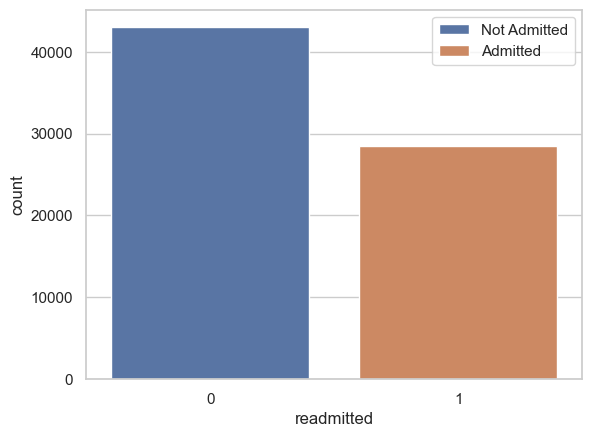

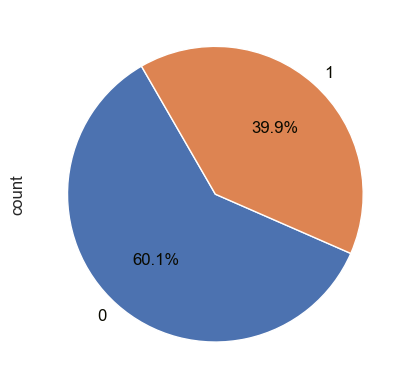

In [10]:
##
plt.figure()
sns.set_theme(style="whitegrid")
ax = sns.countplot(x = 'readmitted', data = data, hue = 'readmitted')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels = ['Not Admitted', 'Admitted'])
plt.figure()
data.readmitted.value_counts().plot.pie(autopct="%1.1f%%", startangle=120,
                                        textprops={'fontsize': 12, 'color':'#0a0a00'})

In [11]:
data.drop(['encounter_id', 'patient_nbr'], axis = 1, inplace = True)
data.drop(data[data.gender == 'Unknown/Invalid'].index, inplace = True)

In [12]:
### lets analyse numeric features
from tqdm import tqdm

data['health_index'] = data.apply(lambda x:  1 / (x['number_emergency'] + x['number_inpatient'] + x['number_outpatient'])
                                  if x['number_emergency'] != 0 or x['number_inpatient'] != 0 or x['number_outpatient'] != 0
                                  else 1, axis = 1)



total = data['time_in_hospital'].sum() + data['num_procedures'].sum() + \
                              data['num_medications'].sum() + data['num_lab_procedures'].sum() + \
                              data['number_diagnoses'].sum()

data['severity_of_disease'] = (data['time_in_hospital'] + data['num_procedures'] + \
                              data['num_medications'] + data['num_lab_procedures'] + \
                              data['number_diagnoses']) / total

drugList = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide',\
            'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol',\
            'troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin',\
            'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']


number_of_changes = []
for i in tqdm(range(len(data))) :
    changeCount = 0
    for col in drugList :
        if data.iloc[i][col] in ['Down', 'Up'] :
            changeCount += 1
    number_of_changes.append(changeCount)

data['number_of_changes'] = number_of_changes

100%|██████████| 71515/71515 [02:47<00:00, 428.23it/s]


In [13]:
data.drop(['weight','race', 'payer_code'], axis = 1, inplace = True)   ## change here

In [14]:
data['discharge_disposition_id'] = data['discharge_disposition_id'].apply(lambda x : 1 if int(x) in [6, 8, 9, 13]
                                                                           else ( 2 if int(x) in [3, 4, 5, 14, 22, 23, 24]
                                                                           else ( 10 if int(x) in [12, 15, 16, 17]
                                                                           else ( 11 if int(x) in [19, 20, 21]
                                                                           else ( 18 if int(x) in [25, 26]
                                                                           else int(x) )))))

data = data[~data.discharge_disposition_id.isin([11,13,14,19,20,21])]

In [15]:
data['admission_type_id'] = data['admission_type_id'].apply(lambda x : 1 if int(x) in [2, 7]
                                                            else ( 5 if int(x) in [6, 8]
                                                            else int(x) ))

In [16]:
data['admission_source_id'] = data['admission_source_id'].apply(lambda x : 1 if int(x) in [2, 3]
                                                            else ( 4 if int(x) in [5, 6, 10, 22, 25]
                                                            else ( 9 if int(x) in [15, 17, 20, 21]
                                                            else ( 11 if int(x) in [13, 14]
                                                            else int(x) ))))

In [17]:
data['max_glu_serum'] = data['max_glu_serum'].apply(lambda x : 200 if x == '>200'
                                                            else ( 300 if x == '>300'
                                                            else ( 100 if x == 'Norm'
                                                            else  0)))

In [18]:
data['A1Cresult'] = data['A1Cresult'].apply(lambda x : 7 if x == '>7'
                                                         else (8 if  x == '>8'
                                                         else ( 5 if x == 'Norm'
                                                         else  0)))

In [19]:
for col in ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide", "examide", "citoglipton", "insulin", "glyburide-metformin", "glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"]:
    data[col] = data[col].apply(lambda x : 10 if x == 'Up'
                                              else ( -10 if x == 'Down'
                                              else ( 0 if x == 'Steady'
                                              else  -20)))


data['change'] = data['change'].apply(lambda x : 1 if x == 'Ch'
                                                 else -1)


data['diabetesMed'] = data['diabetesMed'].apply(lambda x : -1 if x == 'No'
                                                else 1)



In [20]:
#data = pd.read_csv('/content/diabetic_dataset3.csv')

In [21]:
data.columns

Index(['gender', 'age', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'health_index', 'severity_of_disease', 'number_of_changes'],
      dtype='object')

In [22]:
data['readmitted']

0         0
1         1
2         0
3         0
4         0
         ..
101754    1
101755    1
101756    1
101758    0
101765    0
Name: readmitted, Length: 70431, dtype: int64

In [23]:
data.columns

Index(['gender', 'age', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'health_index', 'severity_of_disease', 'number_of_changes'],
      dtype='object')

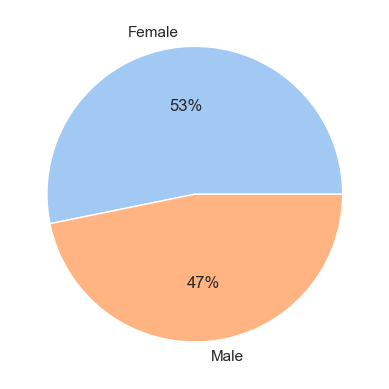

In [24]:
gender_counts = data['gender'].value_counts()

palette_color = sns.color_palette('pastel')
plt.pie(gender_counts, labels=gender_counts.index, colors=palette_color, autopct='%.0f%%')
plt.show()


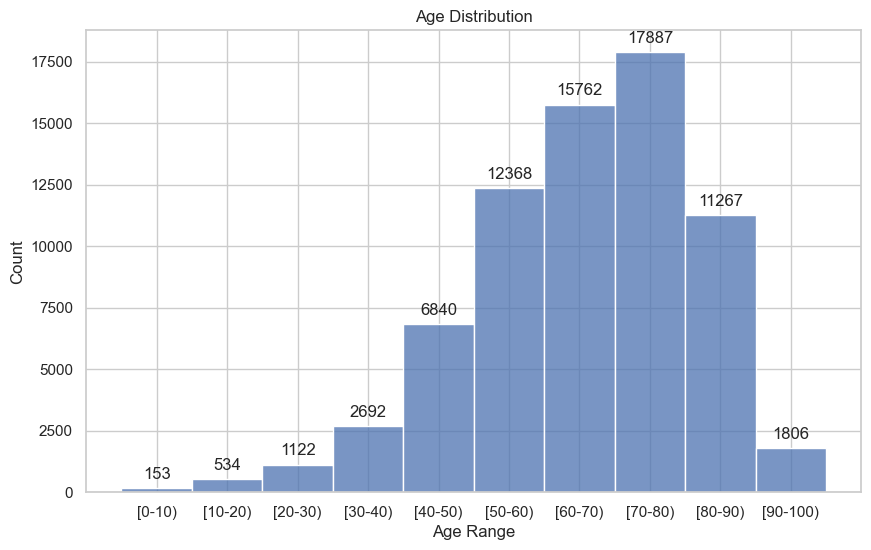

In [25]:
reverseDict = {5: '[0-10)', 15: '[10-20)', 25: '[20-30)', 35: '[30-40)', 45: '[40-50)', 55: '[50-60)', 65: '[60-70)', 75: '[70-80)', 85: '[80-90)', 95: '[90-100)'}

data['age_labels'] = data['age'].apply(lambda x : reverseDict[x])

plt.figure(figsize=(10, 6))
plot = sns.histplot(data['age_labels'], bins=len(reverseDict), discrete=True)
plt.title('Age Distribution')
plt.xlabel('Age Range')
plt.ylabel('Count')

for p in plot.patches:
    plot.annotate(f'{p.get_height()}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')

plt.show()



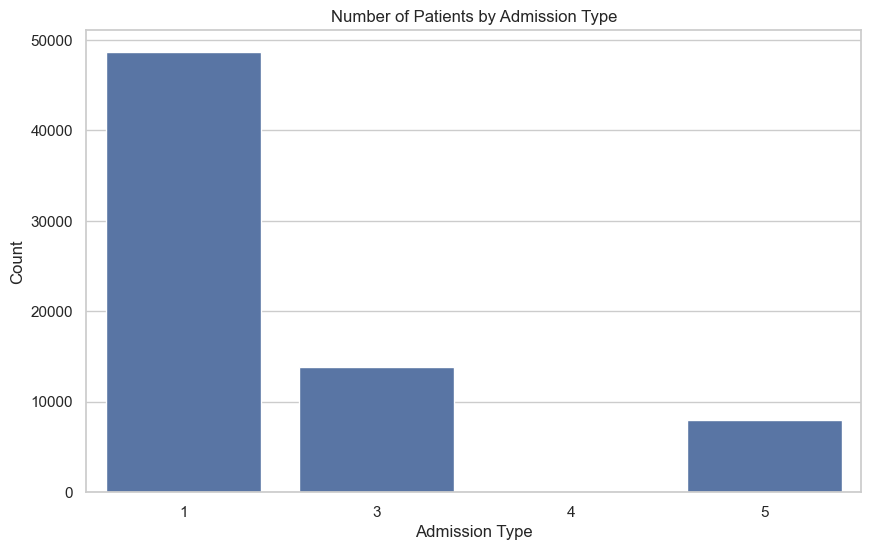

In [26]:
plt.figure(figsize=(10, 6))
sns.countplot(x='admission_type_id', data=data)
plt.title('Number of Patients by Admission Type')
plt.xlabel('Admission Type')
plt.ylabel('Count')
plt.show()

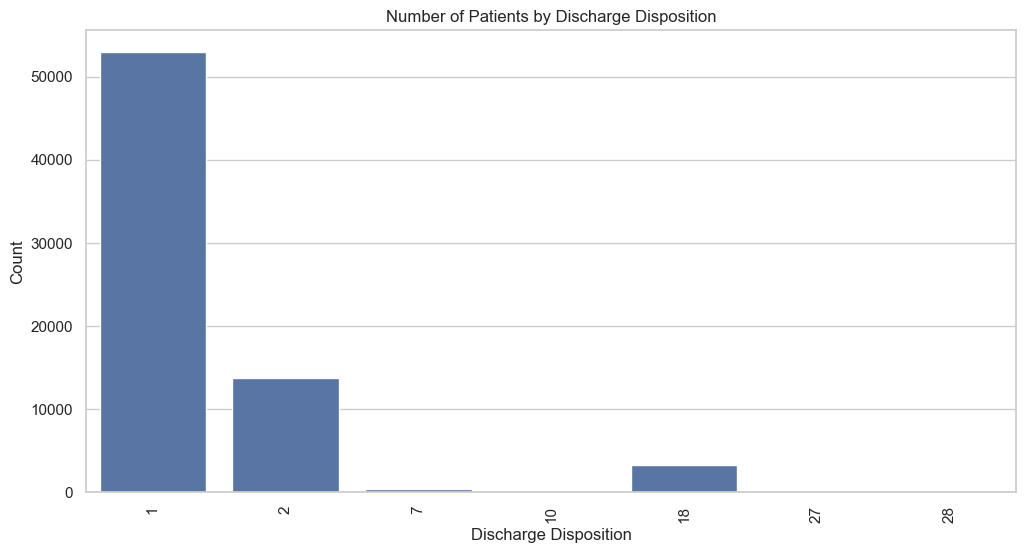

In [27]:
plt.figure(figsize=(12, 6))
sns.countplot(x='discharge_disposition_id', data=data)
plt.title('Number of Patients by Discharge Disposition')
plt.xlabel('Discharge Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

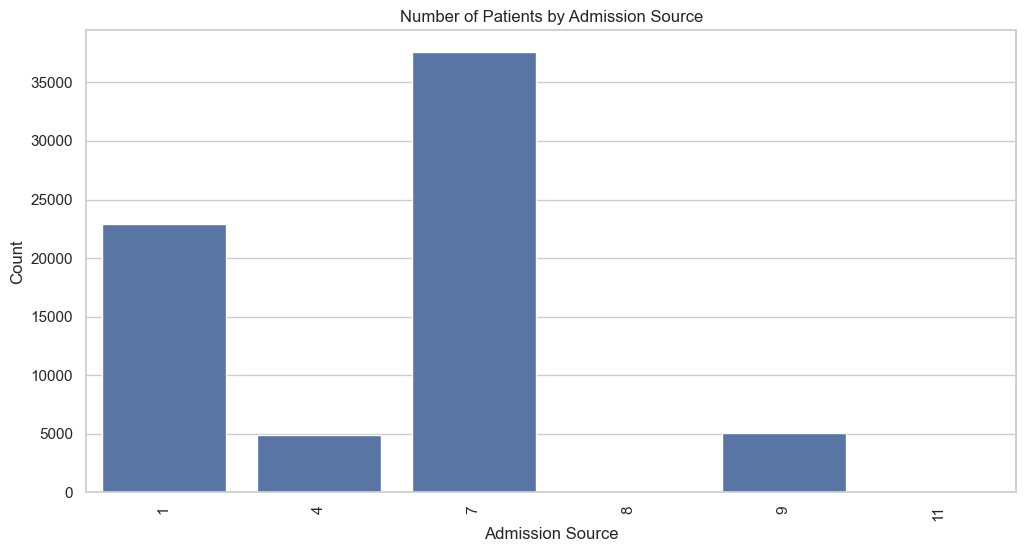

In [28]:
plt.figure(figsize=(12, 6))
sns.countplot(x='admission_source_id', data=data)
plt.title('Number of Patients by Admission Source')
plt.xlabel('Admission Source')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

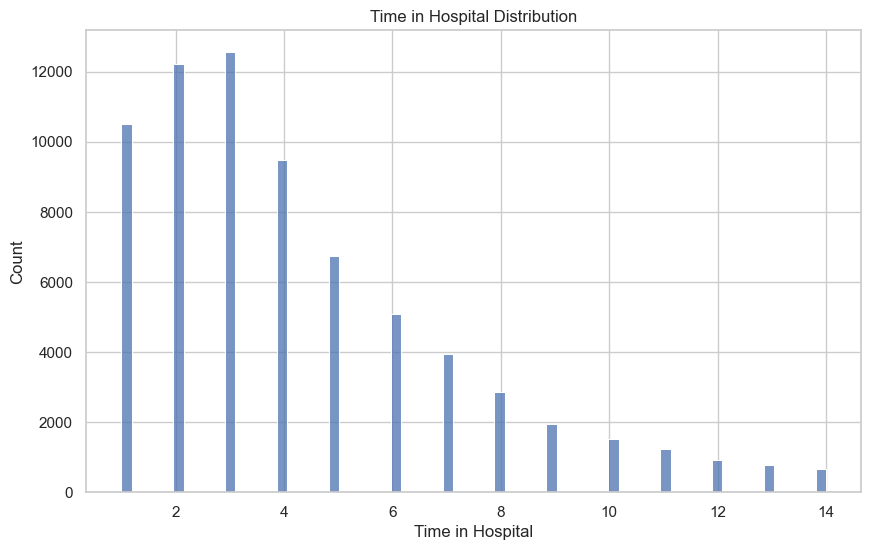

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(data['time_in_hospital'])
plt.title('Time in Hospital Distribution')
plt.xlabel('Time in Hospital')
plt.ylabel('Count')
plt.show()

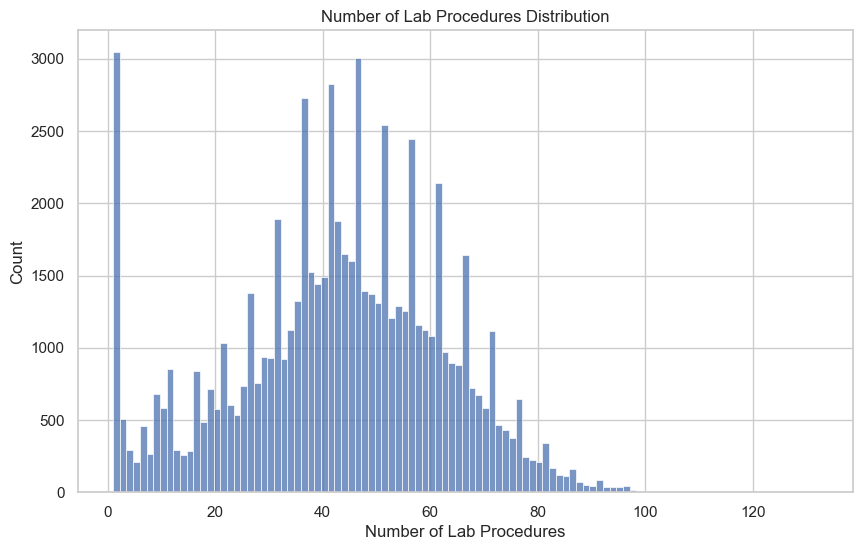

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(data['num_lab_procedures'])
plt.title('Number of Lab Procedures Distribution')
plt.xlabel('Number of Lab Procedures')
plt.ylabel('Count')
plt.show()

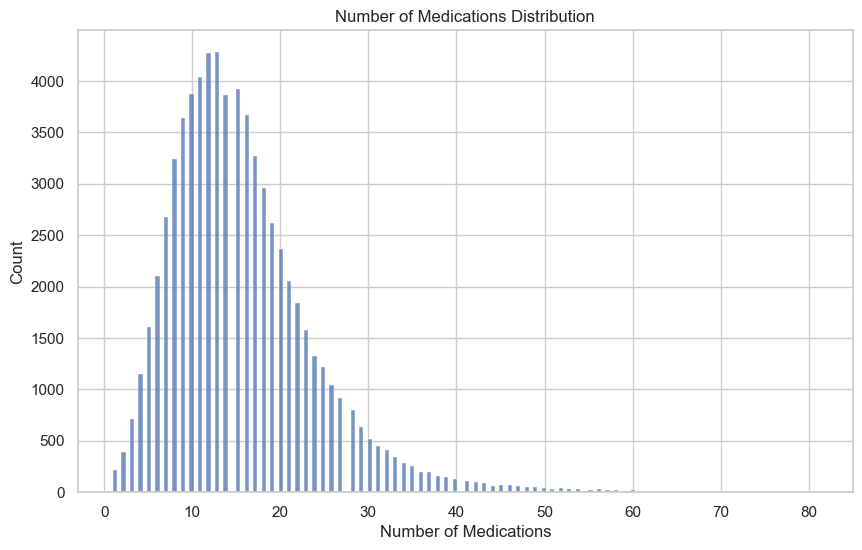

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(data['num_medications'])
plt.title('Number of Medications Distribution')
plt.xlabel('Number of Medications')
plt.ylabel('Count')
plt.show()

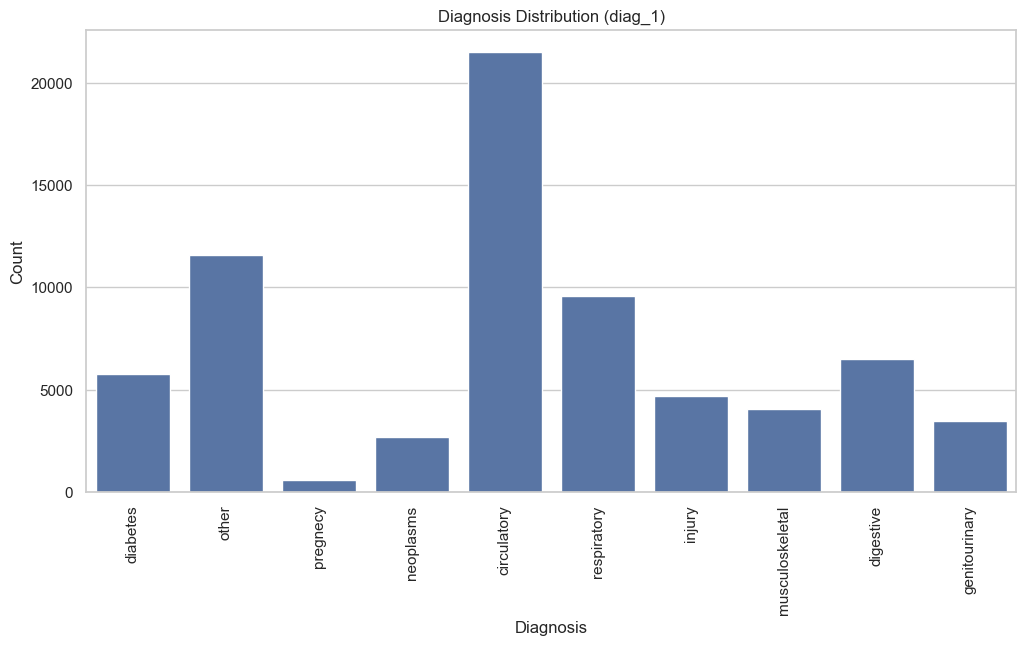

In [32]:
plt.figure(figsize=(12, 6))
sns.countplot(x='diag_1', data=data)
plt.title('Diagnosis Distribution (diag_1)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

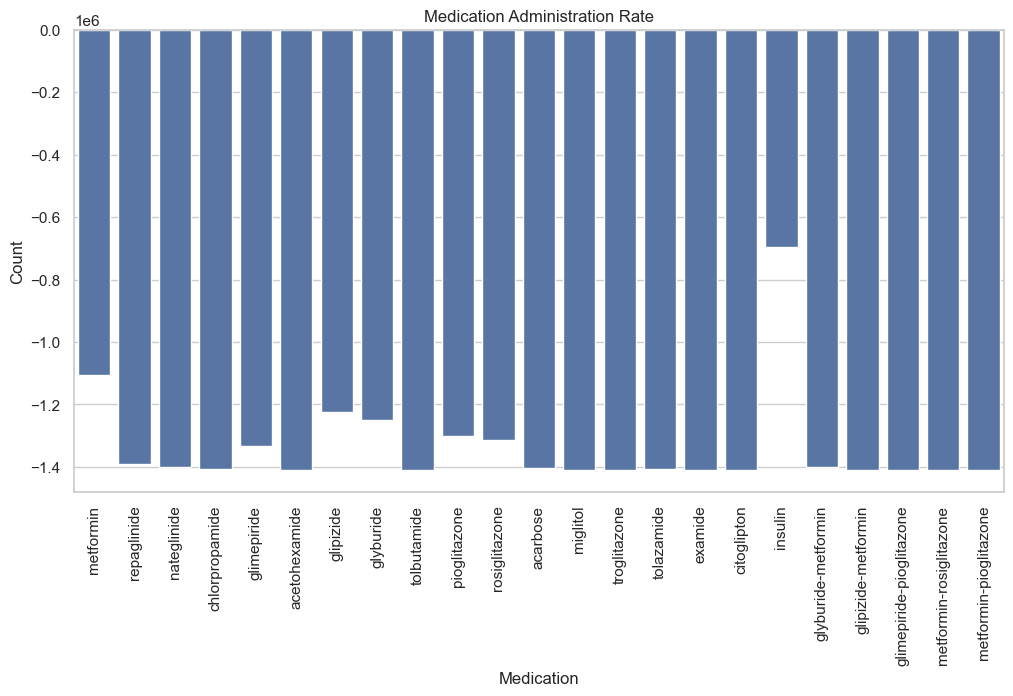

In [33]:
medication_columns = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                      'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
                      'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
                      'tolazamide', 'examide', 'citoglipton', 'insulin',
                      'glyburide-metformin', 'glipizide-metformin',
                      'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                      'metformin-pioglitazone']
medication_data = data[medication_columns].sum().reset_index()
medication_data.columns = ['Medication', 'Count']
plt.figure(figsize=(12, 6))
sns.barplot(x='Medication', y='Count', data=medication_data)
plt.title('Medication Administration Rate')
plt.xlabel('Medication')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

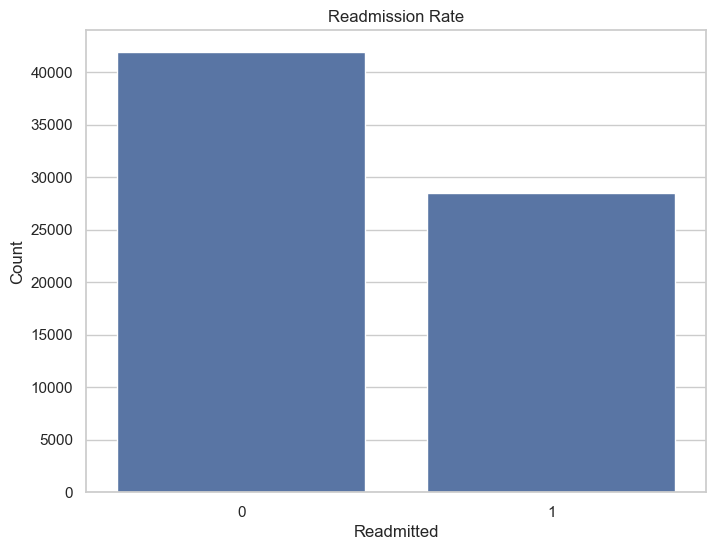

In [34]:
plt.figure(figsize=(8, 6))
sns.countplot(x='readmitted', data=data)
plt.title('Readmission Rate')
plt.xlabel('Readmitted')
plt.ylabel('Count')
plt.show()

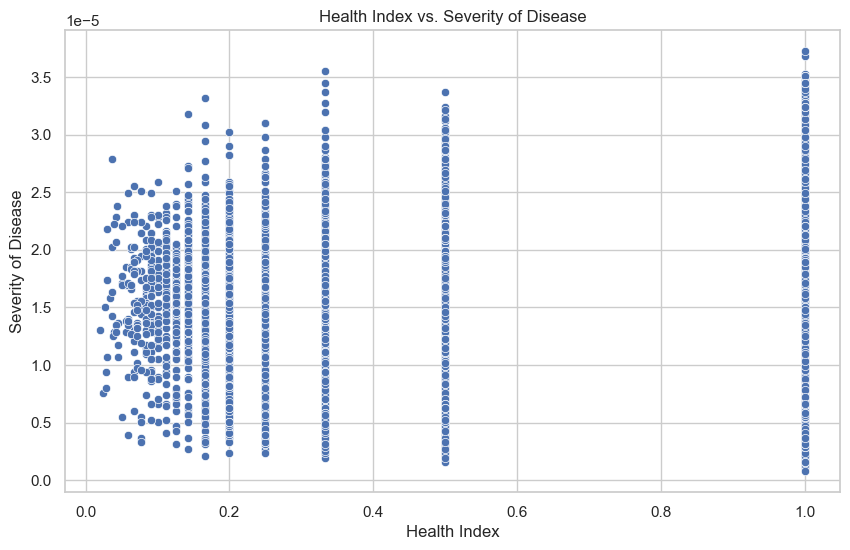

In [35]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='health_index', y='severity_of_disease', data=data)
plt.title('Health Index vs. Severity of Disease')
plt.xlabel('Health Index')
plt.ylabel('Severity of Disease')
plt.show()

In [36]:
# def map_age_to_group(age_range):
#     if age_range in ['[0-10)', '[10-20)', '[20-30)']:
#         return 'Young'
#     elif age_range in ['[30-40)', '[40-50)', '[50-60)']:
#         return 'Middle-Aged'
#     else:
#         return 'Senior'

# df['age_group'] = df['age'].apply(map_age_to_group)

# print(df['age_group'].value_counts())

In [37]:
# categories = ['num_medications', 'num_lab_procedures', 'number_emergency', 'time_in_hospital']

# average_metrics_by_age_group = df.groupby('age_group')[categories].mean().reset_index()

# print(average_metrics_by_age_group)


In [38]:
# data_to_normalize = average_metrics_by_age_group[categories].values

# scaler = MinMaxScaler()
# normalized_data = scaler.fit_transform(data_to_normalize)

# normalized_df = pd.DataFrame(normalized_data, columns=categories)
# normalized_df['age_group'] = average_metrics_by_age_group['age_group']


In [39]:
# def create_radar_chart(data_frame, groups, categories):
#     num_vars = len(categories)

#     angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

#     angles += angles[:1]

#     fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

#     ax.set_theta_offset(np.pi / 2)
#     ax.set_theta_direction(-1)
#     plt.xticks(angles[:-1], categories)

#     ax.set_rlabel_position(0)
#     plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=12)
#     plt.ylim(0,1)

#     for idx, group in enumerate(groups):
#         values = data_frame.loc[data_frame['age_group'] == group].drop('age_group', axis=1).values.flatten().tolist()
#         values += values[:1]
#         ax.plot(angles, values, label=group)
#         ax.fill(angles, values, alpha=0.1)
    
#     plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# create_radar_chart(data, data['age_labels'], categories)
# plt.show()

In [40]:
numeric_features = ['age','time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',
                    'health_index', 'severity_of_disease', 'number_of_changes', 'A1Cresult', 'max_glu_serum',
                    'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide',\
            'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol',\
            'troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin',\
            'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone', 'change', 'diabetesMed']


categorical_features = []
rejected_features = []

for col in data.columns :
    if col not in numeric_features :
        categorical_features.append(col)

for col in categorical_features :
    data_crosstab = pd.crosstab(data['readmitted'],
                                data[col],
                                margins = False)

    stat, p, dof, expected = scipy.stats.chi2_contingency(data_crosstab)
    if p < 0.4 :
	    print(p, col, 'is significant')
    else:
        print(p, col, 'is not significant')
        rejected_features.append(col)

print('\n\n', rejected_features)
data.drop(rejected_features, axis = 1, inplace=True)

1.2094958159533304e-05 gender is significant
5.93295699577205e-64 admission_type_id is significant
6.724160950719454e-32 discharge_disposition_id is significant
4.327667904789753e-108 admission_source_id is significant
5.063372923699428e-32 medical_specialty is significant
8.536250735746521e-62 diag_1 is significant
8.536250735746521e-62 diag_2 is significant
1.4328222569529509e-36 diag_3 is significant
0.0 readmitted is significant
3.057366271920308e-101 age_labels is significant


 []


In [41]:
rejected_features = []
for col in numeric_features :
    rho , pval = scipy.stats.spearmanr(data['readmitted'], data[col])
    print(col, rho, pval)


print('\n\n')
for col in numeric_features :
    rho , pval = scipy.stats.spearmanr(data['readmitted'], data[col])
    if pval < 0.4 :
        print(col, 'is significant')
    else :
        print(col, 'is not significant')
        rejected_features.append(col)

#rejected_features.remove('max_glu_serum')
#rejected_features.remove('A1Cresult')
print(rejected_features)
data.drop(rejected_features, axis = 1, inplace=True)

age 0.07135095583173226 3.683089700271019e-80
time_in_hospital 0.06777643981394682 1.7023616788306636e-72
num_lab_procedures 0.05475941845560129 6.453546138251782e-48
num_procedures -0.028817825076789774 2.0196771653591713e-14
num_medications 0.06062970528831338 2.3548529960357112e-58
number_outpatient 0.08573905864893631 5.054707370065862e-115
number_emergency 0.0899417082340514 2.0118449675641115e-126
number_inpatient 0.14643684449123884 0.0
number_diagnoses 0.10435461008286794 1.0034232068159713e-169
health_index -0.13454813666646742 8.943785818004163e-282
severity_of_disease 0.0730349404508841 6.578749868776572e-84
number_of_changes 0.04178300458245632 1.3509740985122952e-28
A1Cresult -0.01916599178342482 3.64138782358839e-07
max_glu_serum 0.018280109904924083 1.224396239705935e-06
metformin -0.022499839068227927 2.3458376493645316e-09
repaglinide 0.020469095162959115 5.5497410486889906e-08
nateglinide 0.004601999634355191 0.22197166411999703
chlorpropamide 0.0020398121883154147 0.

In [42]:
data.columns

Index(['gender', 'age', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'insulin',
       'glipizide-metformin', 'metformin-rosiglitazone', 'change',
       'diabetesMed', 'readmitted', 'health_index', 'severity_of_disease',
       'number_of_changes', 'age_labels'],
      dtype='object')

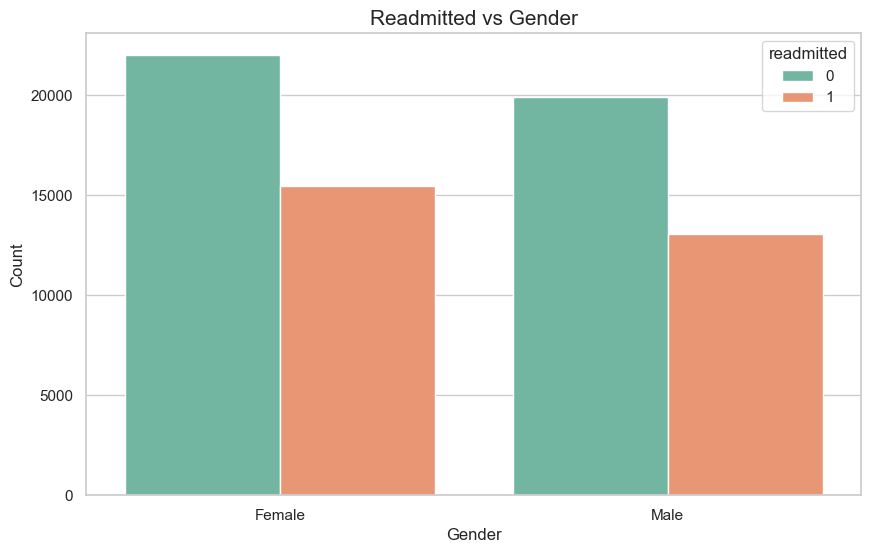

In [43]:
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', hue='readmitted', data=data, palette='Set2')
plt.title('Readmitted vs Gender', fontsize=15)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


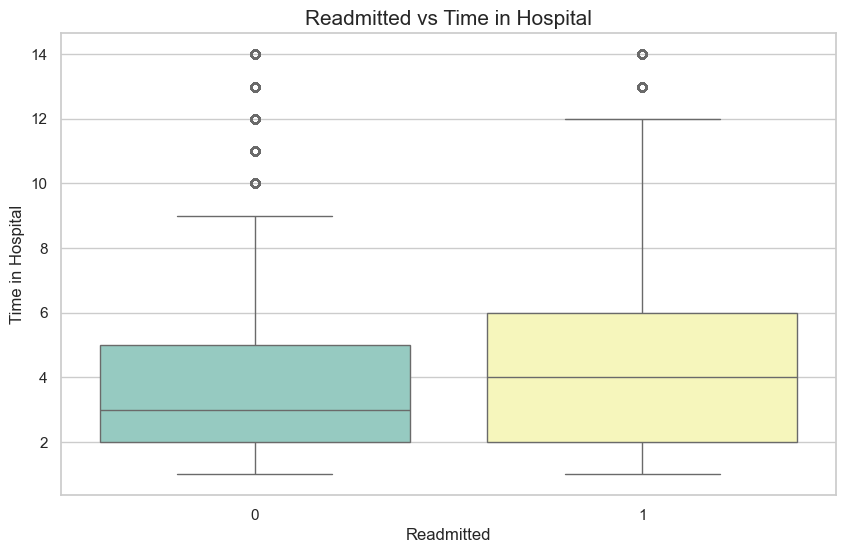

In [44]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='readmitted', y='time_in_hospital', data=data, palette='Set3')
plt.title('Readmitted vs Time in Hospital', fontsize=15)
plt.xlabel('Readmitted', fontsize=12)
plt.ylabel('Time in Hospital', fontsize=12)
plt.show()


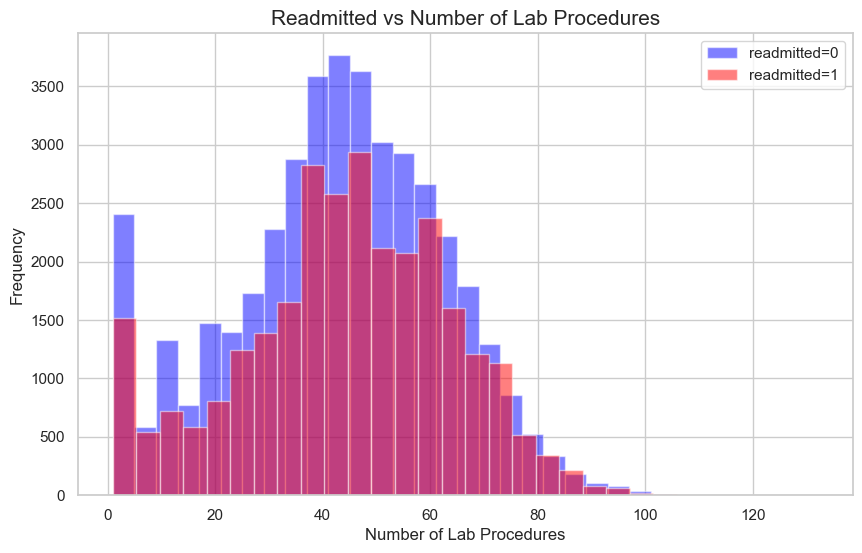

In [45]:
plt.figure(figsize=(10, 6))
data[data['readmitted'] == 0]['num_lab_procedures'].hist(alpha=0.5, color='blue', bins=30, label='readmitted=0')
data[data['readmitted'] == 1]['num_lab_procedures'].hist(alpha=0.5, color='red', bins=30, label='readmitted=1')
plt.title('Readmitted vs Number of Lab Procedures', fontsize=15)
plt.xlabel('Number of Lab Procedures', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()


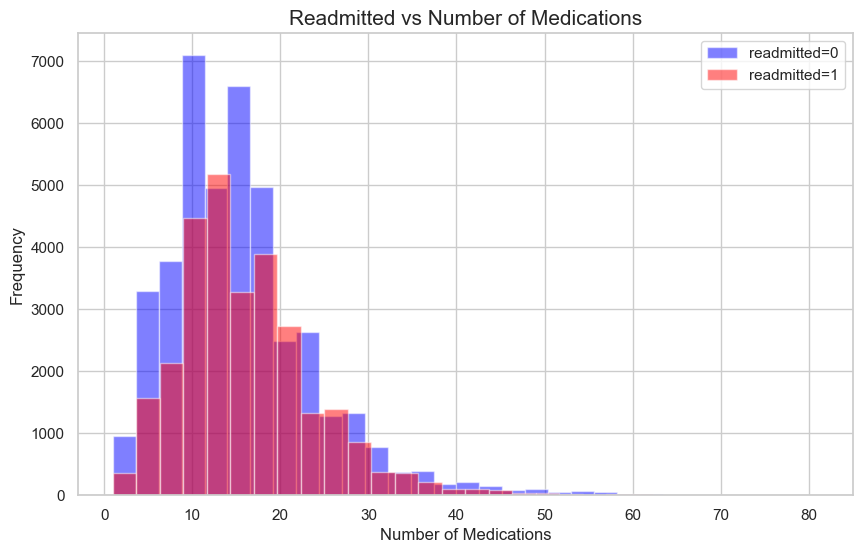

In [46]:
plt.figure(figsize=(10, 6))
data[data['readmitted'] == 0]['num_medications'].hist(alpha=0.5, color='blue', bins=30, label='readmitted=0')
data[data['readmitted'] == 1]['num_medications'].hist(alpha=0.5, color='red', bins=30, label='readmitted=1')
plt.title('Readmitted vs Number of Medications', fontsize=15)
plt.xlabel('Number of Medications', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()


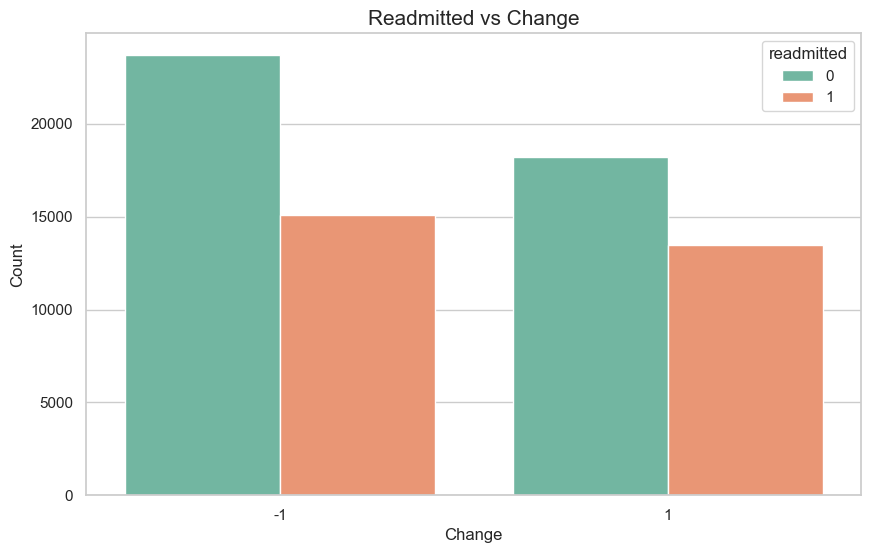

In [47]:
plt.figure(figsize=(10, 6))
sns.countplot(x='change', hue='readmitted', data=data, palette='Set2')
plt.title('Readmitted vs Change', fontsize=15)
plt.xlabel('Change', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


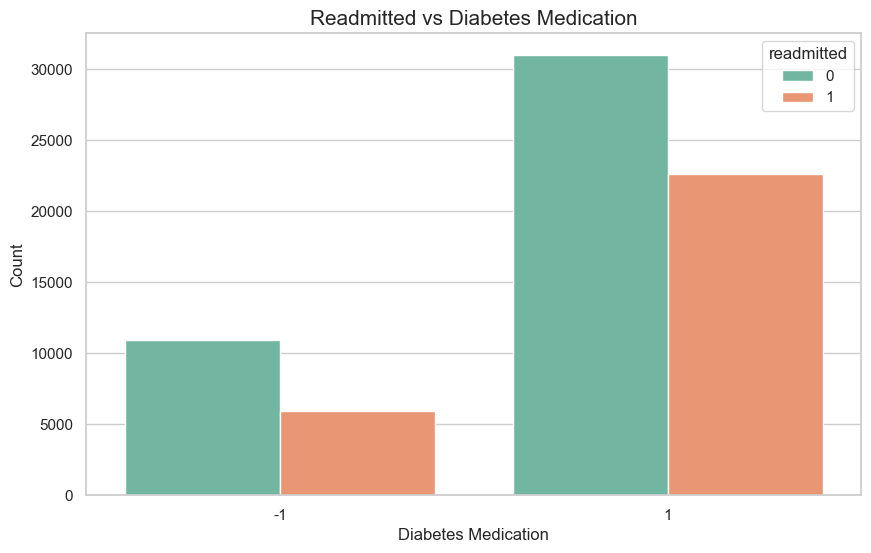

In [48]:
plt.figure(figsize=(10, 6))
sns.countplot(x='diabetesMed', hue='readmitted', data=data, palette='Set2')
plt.title('Readmitted vs Diabetes Medication', fontsize=15)
plt.xlabel('Diabetes Medication', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


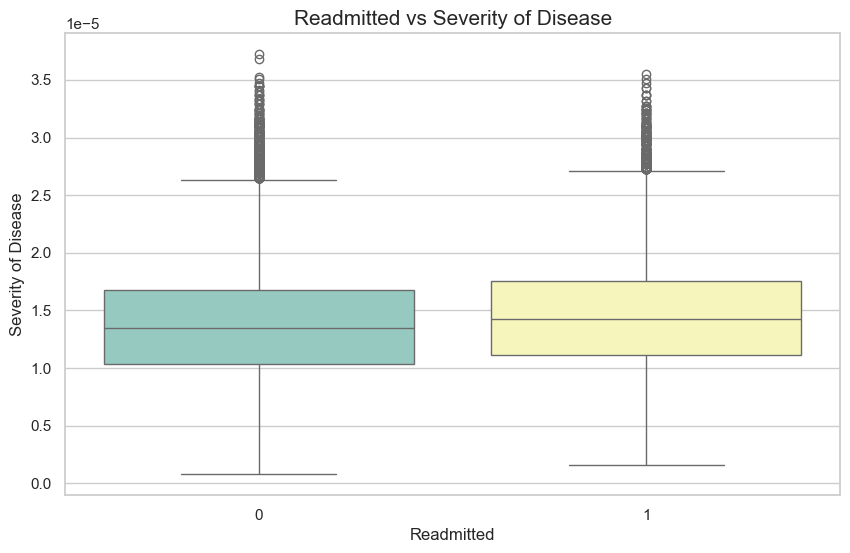

In [49]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='readmitted', y='severity_of_disease', data=data, palette='Set3')
plt.title('Readmitted vs Severity of Disease', fontsize=15)
plt.xlabel('Readmitted', fontsize=12)
plt.ylabel('Severity of Disease', fontsize=12)
plt.show()


In [50]:
selected_features = ['readmitted', 'health_index', 'number_inpatient', 'num_medications', 'time_in_hospital', 'number_outpatient', 'number_diagnoses','number_emergency', 'age', 'A1Cresult', 'diabetesMed']


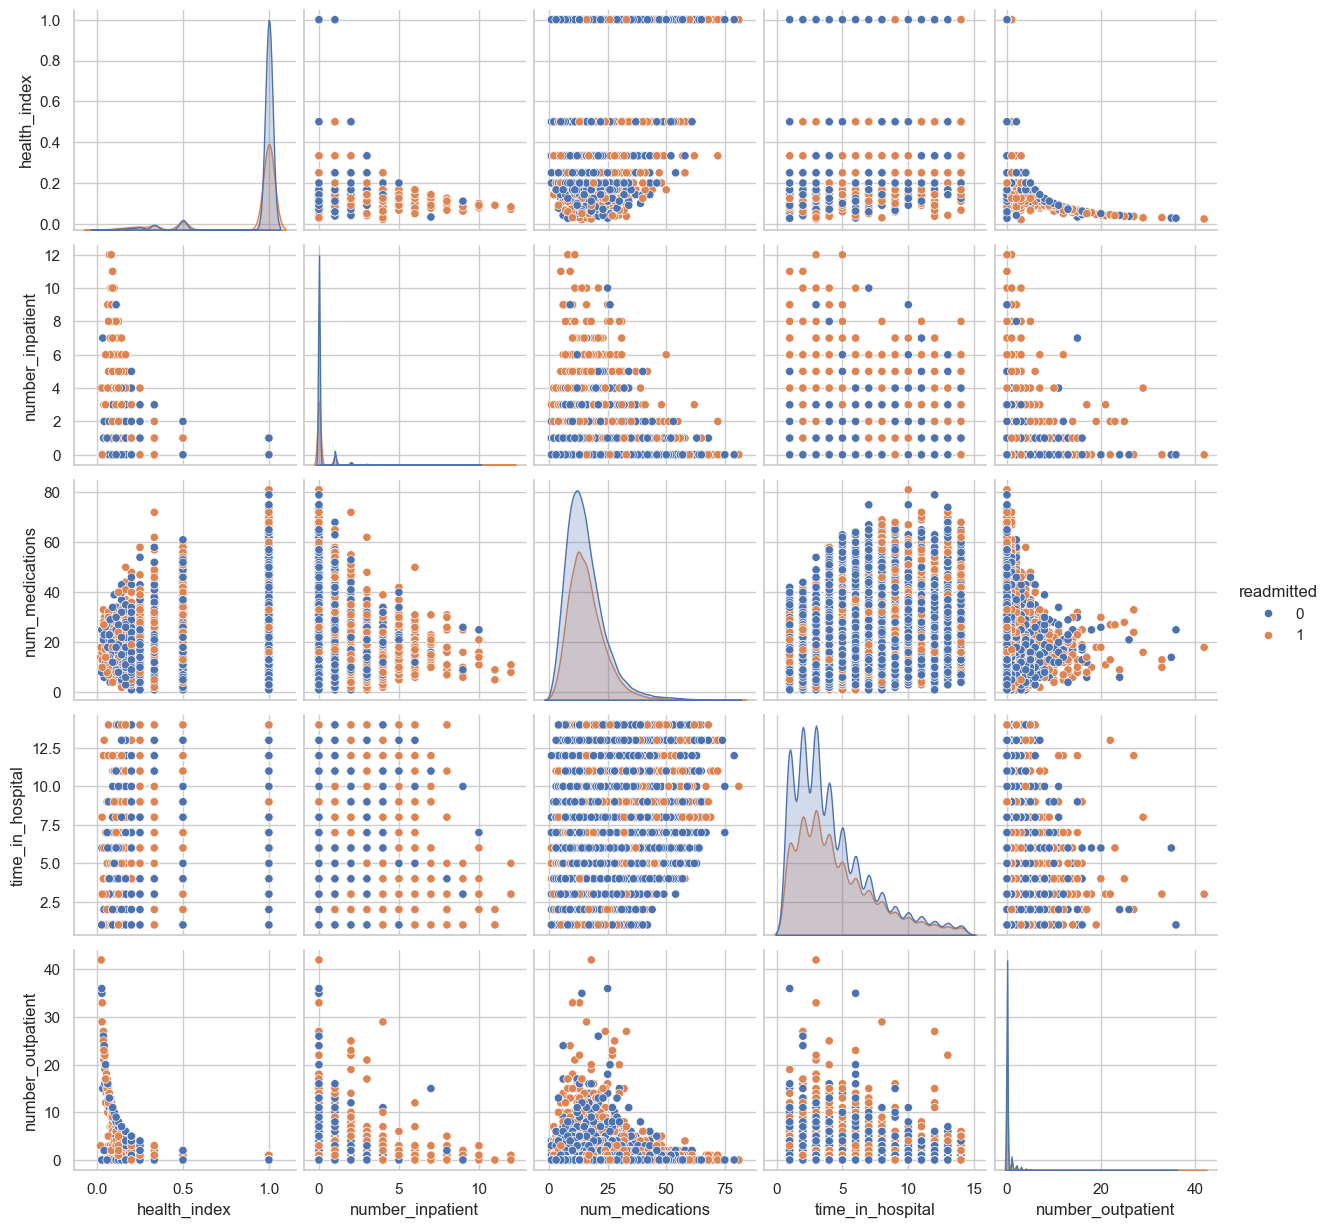

In [51]:
selected_features_1 = ['readmitted', 'health_index', 'number_inpatient', 'num_medications', 'time_in_hospital', 'number_outpatient']
sns.pairplot(data[selected_features_1], hue='readmitted')


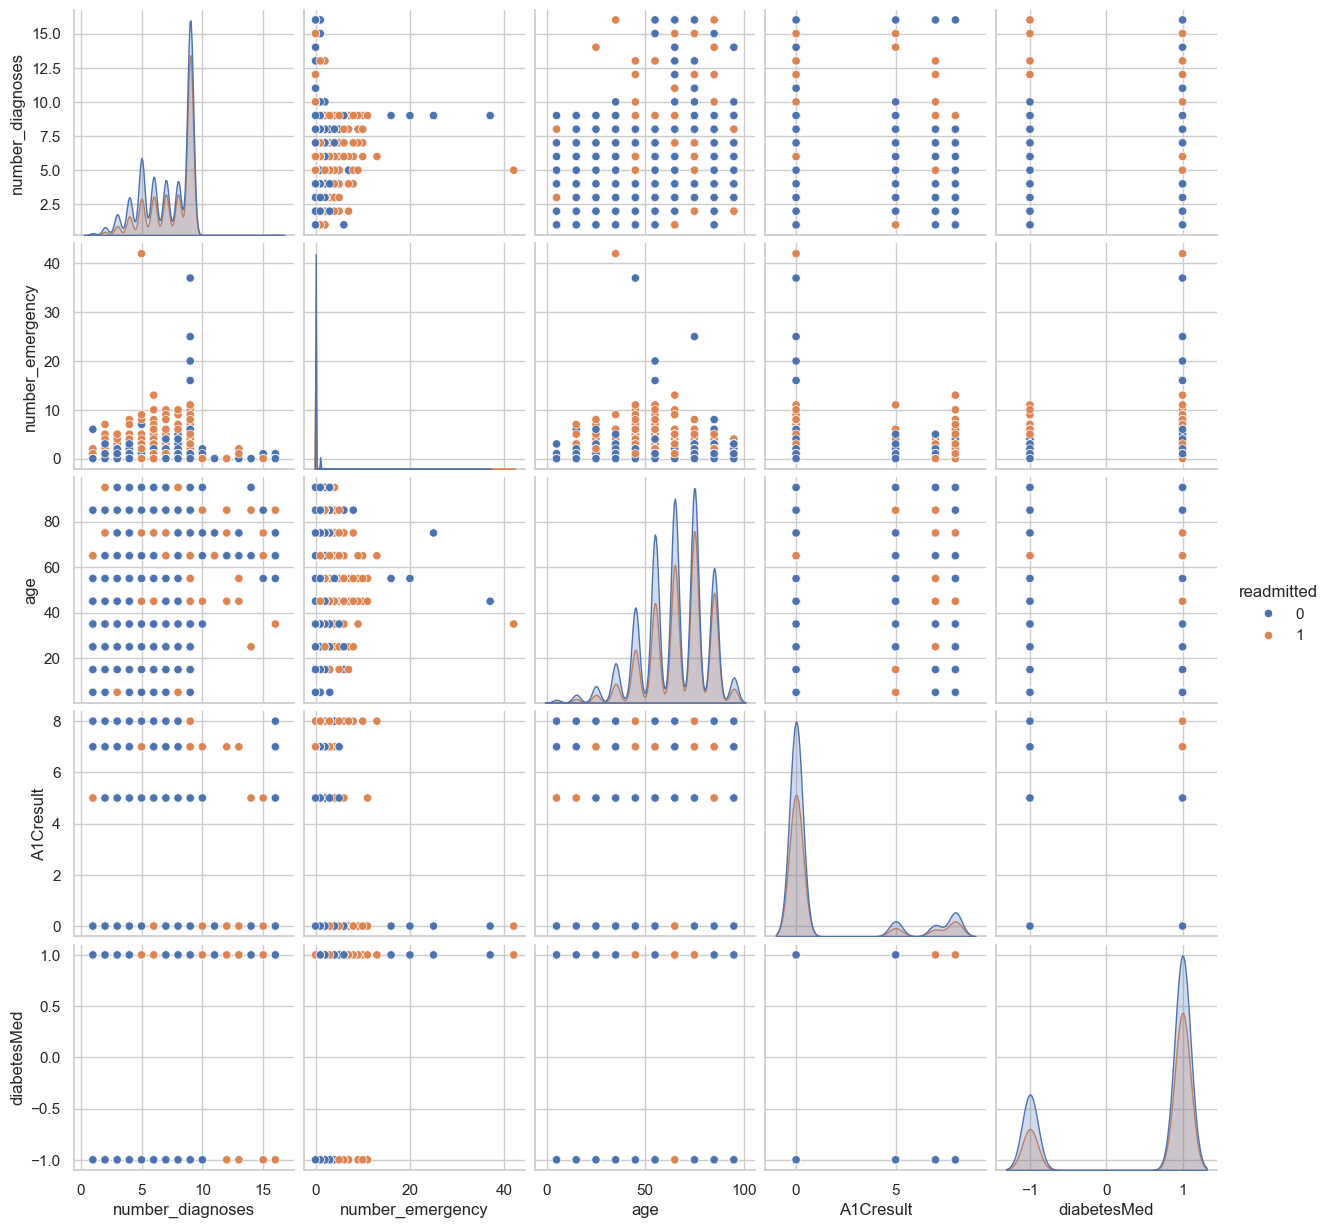

In [52]:
selected_features_2 = ['readmitted', 'number_diagnoses','number_emergency', 'age', 'A1Cresult', 'diabetesMed']
sns.pairplot(data[selected_features_2], hue='readmitted')


<Axes: >

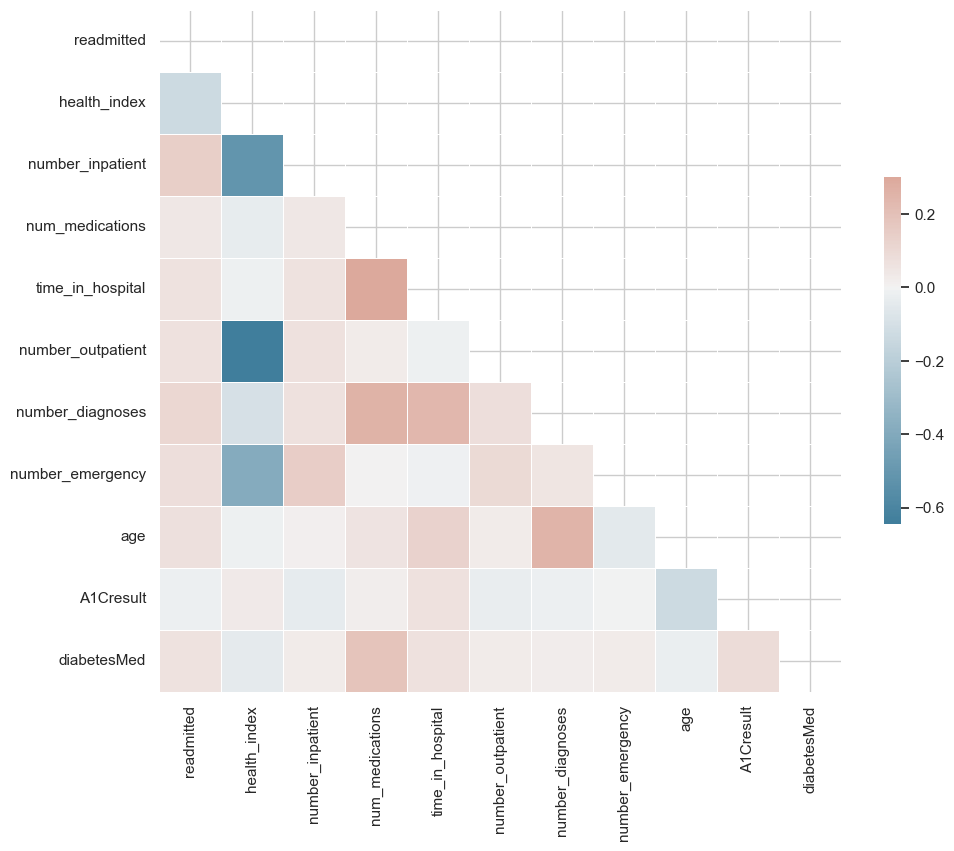

In [53]:
corr = data[selected_features].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [55]:
cat_new = []
for col in categorical_features :
    if col in data.columns :
        print(col, '-->', np.unique(data[col]), '\n')
        cat_new.append(col)

numeric_features = []

for col in data.columns :
    if col  not in cat_new :
        numeric_features.append(col)

gender --> ['Female' 'Male'] 

admission_type_id --> [1 3 4 5] 

discharge_disposition_id --> [ 1  2  7 10 18 27 28] 

admission_source_id --> [ 1  4  7  8  9 11] 

medical_specialty --> ['high_freq' 'low_freq' 'missing' 'neurology' 'pediatrics' 'psychic'
 'surgery' 'ungrouped'] 

diag_1 --> ['circulatory' 'diabetes' 'digestive' 'genitourinary' 'injury'
 'musculoskeletal' 'neoplasms' 'other' 'pregnecy' 'respiratory'] 

diag_2 --> ['circulatory' 'diabetes' 'digestive' 'genitourinary' 'injury'
 'musculoskeletal' 'neoplasms' 'other' 'pregnecy' 'respiratory'] 

diag_3 --> ['circulatory' 'diabetes' 'digestive' 'genitourinary' 'injury'
 'musculoskeletal' 'neoplasms' 'other' 'pregnecy' 'respiratory'] 

readmitted --> [0 1] 

age_labels --> ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)'] 



In [56]:
data[cat_new]

,gender,admission_type_id,discharge_disposition_id,admission_source_id,medical_specialty,diag_1,diag_2,diag_3,readmitted,age_labels
0,Female,5,18,1,pediatrics,diabetes,diabetes,diabetes,0,[0-10)
1,Female,1,1,7,missing,other,other,other,1,[10-20)
2,Female,1,1,7,missing,pregnecy,pregnecy,other,0,[20-30)
3,Male,1,1,7,missing,other,other,circulatory,0,[30-40)
4,Male,1,1,7,missing,neoplasms,neoplasms,diabetes,0,[40-50)
...,...,...,...,...,...,...,...,...,...,...
101754,Female,1,1,7,missing,digestive,digestive,diabetes,1,[70-80)
101755,Female,1,1,7,missing,genitourinary,genitourinary,respiratory,1,[40-50)
101756,Female,1,1,7,missing,injury,injury,circulatory,1,[60-70)
101758,Female,1,1,7,missing,other,other,other,0,[80-90)


In [57]:
datare = data['readmitted']

In [58]:
data.drop(columns = 'readmitted', inplace = True)

In [59]:
data

,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,troglitazone,insulin,glipizide-metformin,metformin-rosiglitazone,change,diabetesMed,health_index,severity_of_disease,number_of_changes,age_labels
0,Female,5,5,18,1,1,pediatrics,41,0,1,...,-20,-20,-20,-20,-1,-1,1.000000,0.000009,0,[0-10)
1,Female,15,1,1,7,3,missing,59,0,18,...,-20,10,-20,-20,1,1,1.000000,0.000017,1,[10-20)
2,Female,25,1,1,7,2,missing,11,5,13,...,-20,-20,-20,-20,-1,1,0.333333,0.000007,0,[20-30)
3,Male,35,1,1,7,2,missing,44,1,16,...,-20,10,-20,-20,1,1,1.000000,0.000014,1,[30-40)
4,Male,45,1,1,7,1,missing,51,0,8,...,-20,0,-20,-20,1,1,1.000000,0.000013,0,[40-50)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,Female,75,1,1,7,9,missing,50,2,33,...,-20,0,-20,-20,1,1,1.000000,0.000020,1,[70-80)
101755,Female,45,1,1,7,14,missing,73,6,26,...,-20,10,-20,-20,1,1,1.000000,0.000025,1,[40-50)
101756,Female,65,1,1,7,2,missing,46,6,17,...,-20,0,-20,-20,-1,1,0.333333,0.000016,0,[60-70)
101758,Female,85,1,1,7,5,missing,76,1,22,...,-20,10,-20,-20,1,1,1.000000,0.000022,1,[80-90)


In [60]:
columns_to_encode = [col for col in cat_new if col != 'readmitted']
data_encoded = pd.get_dummies(data, columns=columns_to_encode)


In [61]:
data_encoded

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,...,age_labels_[0-10),age_labels_[10-20),age_labels_[20-30),age_labels_[30-40),age_labels_[40-50),age_labels_[50-60),age_labels_[60-70),age_labels_[70-80),age_labels_[80-90),age_labels_[90-100)
0,5,1,41,0,1,0,0,0,1,0,...,True,False,False,False,False,False,False,False,False,False
1,15,3,59,0,18,0,0,0,9,0,...,False,True,False,False,False,False,False,False,False,False
2,25,2,11,5,13,2,0,1,6,0,...,False,False,True,False,False,False,False,False,False,False
3,35,2,44,1,16,0,0,0,7,0,...,False,False,False,True,False,False,False,False,False,False
4,45,1,51,0,8,0,0,0,5,0,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,75,9,50,2,33,0,0,0,9,0,...,False,False,False,False,False,False,False,True,False,False
101755,45,14,73,6,26,0,1,0,9,0,...,False,False,False,False,True,False,False,False,False,False
101756,65,2,46,6,17,1,1,1,9,0,...,False,False,False,False,False,False,True,False,False,False
101758,85,5,76,1,22,0,1,0,9,0,...,False,False,False,False,False,False,False,False,True,False


In [62]:
data_encoded.columns

Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'insulin',
       'glipizide-metformin', 'metformin-rosiglitazone', 'change',
       'diabetesMed', 'health_index', 'severity_of_disease',
       'number_of_changes', 'gender_Female', 'gender_Male',
       'admission_type_id_1', 'admission_type_id_3', 'admission_type_id_4',
       'admission_type_id_5', 'discharge_disposition_id_1',
       'discharge_disposition_id_2', 'discharge_disposition_id_7',
       'discharge_disposition_id_10', 'discharge_disposition_id_18',
       'discharge_disposition_id_27', 'discharge_disposition_id_28',
       'admission_source_id_1', 'admission_sour

In [63]:
concatenated_data = pd.concat([data_encoded, datare], axis=1)


In [64]:
concatenated_data.columns

Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'insulin',
       'glipizide-metformin', 'metformin-rosiglitazone', 'change',
       'diabetesMed', 'health_index', 'severity_of_disease',
       'number_of_changes', 'gender_Female', 'gender_Male',
       'admission_type_id_1', 'admission_type_id_3', 'admission_type_id_4',
       'admission_type_id_5', 'discharge_disposition_id_1',
       'discharge_disposition_id_2', 'discharge_disposition_id_7',
       'discharge_disposition_id_10', 'discharge_disposition_id_18',
       'discharge_disposition_id_27', 'discharge_disposition_id_28',
       'admission_source_id_1', 'admission_sour

In [65]:
X_train, X_temp, y_train, y_temp = train_test_split(concatenated_data.drop('readmitted', axis=1), concatenated_data['readmitted'], test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (56344, 98)
Validation set shape: (7043, 98)
Testing set shape: (7044, 98)


In [66]:
rf_classifier = RandomForestClassifier(random_state=42)

rf_classifier.fit(X_train, y_train)

val_predictions = rf_classifier.predict(X_val)

val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)

test_predictions = rf_classifier.predict(X_test)

test_accuracy = accuracy_score(y_test, test_predictions)
print("Test Accuracy:", test_accuracy)


Validation Accuracy: 0.6200482748828624
Test Accuracy: 0.6276263486655309


In [67]:
AUC_RF = roc_auc_score(y_test, test_predictions)

F1_POS = f1_score(y_test, test_predictions, pos_label=1)

F1_NEG = f1_score(y_test, test_predictions, pos_label=0)

Harmonic_F1_RF = 2 * (F1_POS * F1_NEG) / (F1_POS + F1_NEG)

print("AUC_RF:", AUC_RF)
print("F1_POS:", F1_POS)
print("F1_NEG:", F1_NEG)
print("Harmonic_F1_RF:", Harmonic_F1_RF)


AUC_RF: 0.5791804449932154
F1_POS: 0.41490073611420925
F1_NEG: 0.7269130661114003
Harmonic_F1_RF: 0.5282766167877602


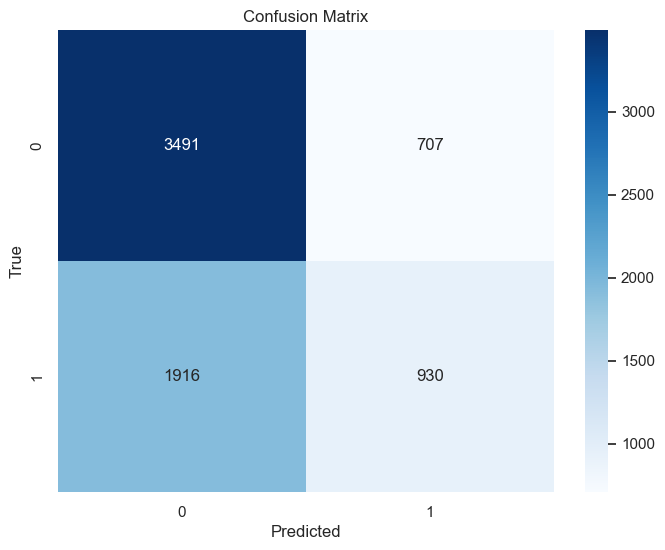

In [68]:
conf_matrix = confusion_matrix(y_test, test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Validation Accuracy (Logistic Regression): 0.6277154621610109
Test Accuracy (Logistic Regression): 0.6330210107893243
AUC_logreg: 0.566392673685592
F1_POS_logreg: 0.3255935298721628
F1_NEG_logreg: 0.7479278400780107
Harmonic_F1_logreg: 0.45368536175849905


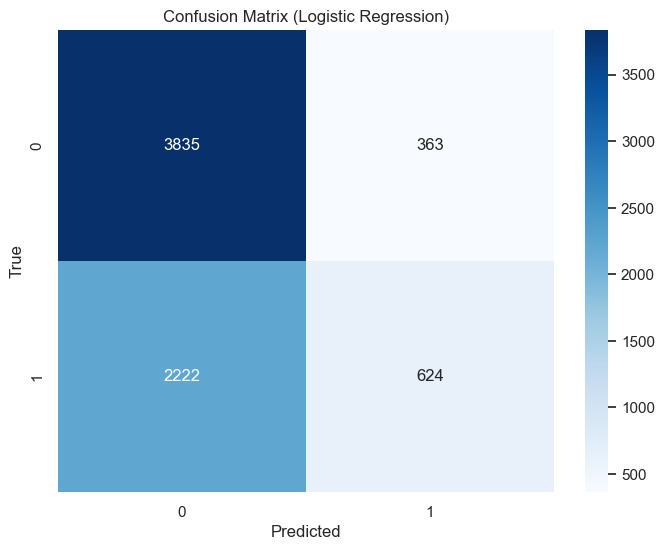

In [69]:
logreg_classifier = LogisticRegression(random_state=42)

logreg_classifier.fit(X_train, y_train)

val_predictions_logreg = logreg_classifier.predict(X_val)

val_accuracy_logreg = accuracy_score(y_val, val_predictions_logreg)
print("Validation Accuracy (Logistic Regression):", val_accuracy_logreg)

test_predictions_logreg = logreg_classifier.predict(X_test)

test_accuracy_logreg = accuracy_score(y_test, test_predictions_logreg)
print("Test Accuracy (Logistic Regression):", test_accuracy_logreg)

AUC_logreg = roc_auc_score(y_test, test_predictions_logreg)

F1_POS_logreg = f1_score(y_test, test_predictions_logreg, pos_label=1)

F1_NEG_logreg = f1_score(y_test, test_predictions_logreg, pos_label=0)

Harmonic_F1_logreg = 2 * (F1_POS_logreg * F1_NEG_logreg) / (F1_POS_logreg + F1_NEG_logreg)

print("AUC_logreg:", AUC_logreg)
print("F1_POS_logreg:", F1_POS_logreg)
print("F1_NEG_logreg:", F1_NEG_logreg)
print("Harmonic_F1_logreg:", Harmonic_F1_logreg)

conf_matrix_logreg = confusion_matrix(y_test, test_predictions_logreg)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logreg, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [70]:
# !pip install catboost


Validation Accuracy (CatBoost): 0.633962799943206
Test Accuracy (CatBoost): 0.6448040885860307
AUC_catboost: 0.5973829856401853
F1_POS_catboost: 0.4435053380782918
F1_NEG_catboost: 0.7391576313594662
Harmonic_F1_catboost: 0.5543766291170448


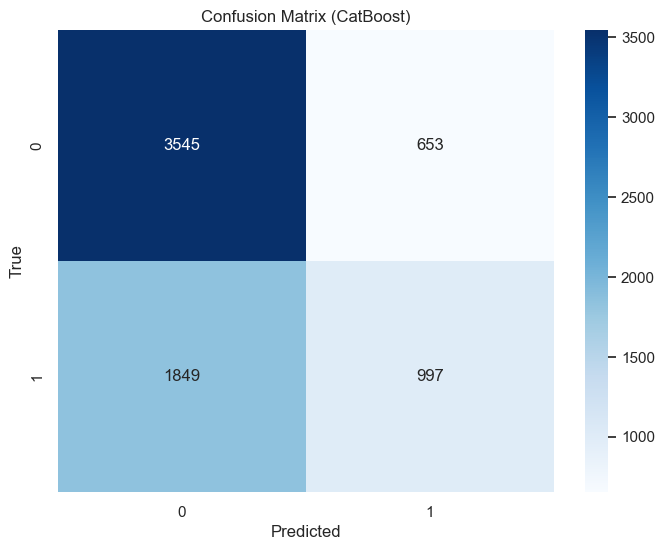

In [71]:
catboost_classifier = CatBoostClassifier(random_state=42, verbose=0)

catboost_classifier.fit(X_train, y_train)

val_predictions_catboost = catboost_classifier.predict(X_val)

val_accuracy_catboost = accuracy_score(y_val, val_predictions_catboost)
print("Validation Accuracy (CatBoost):", val_accuracy_catboost)

test_predictions_catboost = catboost_classifier.predict(X_test)

test_accuracy_catboost = accuracy_score(y_test, test_predictions_catboost)
print("Test Accuracy (CatBoost):", test_accuracy_catboost)

AUC_catboost = roc_auc_score(y_test, test_predictions_catboost)

F1_POS_catboost = f1_score(y_test, test_predictions_catboost, pos_label=1)

F1_NEG_catboost = f1_score(y_test, test_predictions_catboost, pos_label=0)

Harmonic_F1_catboost = 2 * (F1_POS_catboost * F1_NEG_catboost) / (F1_POS_catboost + F1_NEG_catboost)

print("AUC_catboost:", AUC_catboost)
print("F1_POS_catboost:", F1_POS_catboost)
print("F1_NEG_catboost:", F1_NEG_catboost)
print("Harmonic_F1_catboost:", Harmonic_F1_catboost)

conf_matrix_catboost = confusion_matrix(y_test, test_predictions_catboost)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_catboost, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title("Confusion Matrix (CatBoost)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [72]:
metrics = {
    "Random Forest": {"Accuracy": test_accuracy, "AUC": AUC_RF, "Harmonic F1": Harmonic_F1_RF},
    "Logistic Regression": {"Accuracy": test_accuracy_logreg, "AUC": AUC_logreg, "Harmonic F1": Harmonic_F1_logreg},
    "CatBoost": {"Accuracy": test_accuracy_catboost, "AUC": AUC_catboost, "Harmonic F1": Harmonic_F1_catboost}
}

print("Comparison of Models:")
print("======================")
for model, scores in metrics.items():
    print(f"Model: {model}")
    print(f"Accuracy: {scores['Accuracy']:.4f}")
    print(f"AUC: {scores['AUC']:.4f}")
    print(f"Harmonic F1: {scores['Harmonic F1']:.4f}")
    print()


Comparison of Models:
Model: Random Forest
Accuracy: 0.6276
AUC: 0.5792
Harmonic F1: 0.5283

Model: Logistic Regression
Accuracy: 0.6330
AUC: 0.5664
Harmonic F1: 0.4537

Model: CatBoost
Accuracy: 0.6448
AUC: 0.5974
Harmonic F1: 0.5544



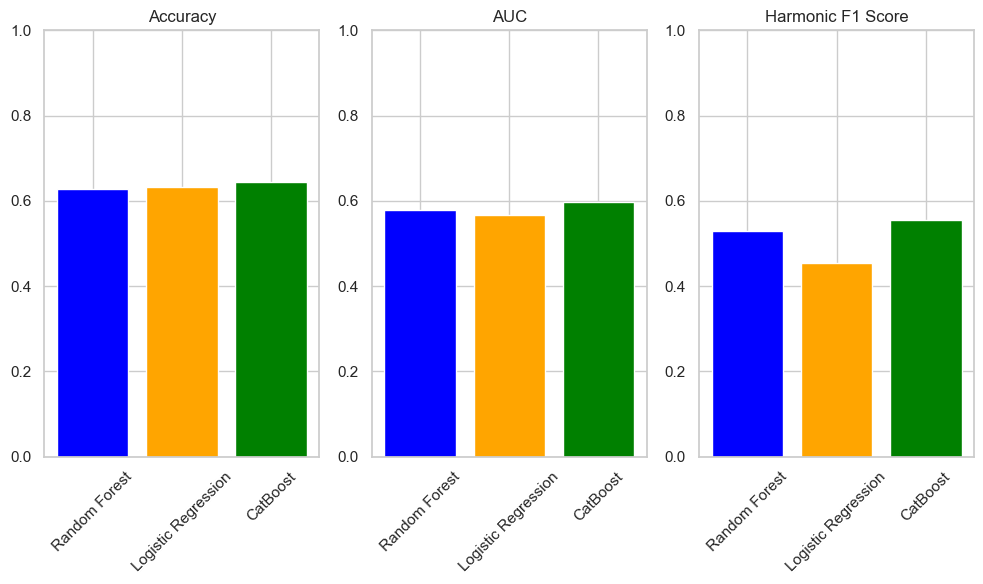

In [73]:
models = ["Random Forest", "Logistic Regression", "CatBoost"]
accuracies = [test_accuracy, test_accuracy_logreg, test_accuracy_catboost]
aucs = [AUC_RF, AUC_logreg, AUC_catboost]
harmonic_f1_scores = [Harmonic_F1_RF, Harmonic_F1_logreg, Harmonic_F1_catboost]

plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.title('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.bar(models, aucs, color=['blue', 'orange', 'green'])
plt.title('AUC')
plt.ylim(0, 1)
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.bar(models, harmonic_f1_scores, color=['blue', 'orange', 'green'])
plt.title('Harmonic F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [77]:
from sklearn.metrics import plot_roc_curve

# Random Forest
rf_disp = plot_roc_curve(rf_classifier, X_test, y_test)
# Logistic Regression
logreg_disp = plot_roc_curve(logreg_classifier, X_test, y_test, ax=rf_disp.ax_)
# CatBoost
catboost_disp = plot_roc_curve(catboost_classifier, X_test, y_test, ax=logreg_disp.ax_)

# Display the plot
plt.show()


ImportError: cannot import name 'plot_roc_curve' from 'sklearn.metrics' (C:\Users\nirmi\.conda\envs\jupyterlab\Lib\site-packages\sklearn\metrics\__init__.py)